In [169]:
# Codice per clonare la repository di github con tutti i dati. Va eseguito una sola volta
# (per questo si controlla se la cartella esista già o meno)
# È stato scelto questo metodo per permettere a tutti, sia da google colab che in locale,
# di avere i dati a disposizione

# Se si esegue in locale, assicurarsi di avere git installato
# Al link della repository sono visionabili tutti i file
from os import path
if not path.exists("Laboratorio_Fisica_3"):
    !git clone https://github.com/MasterRoby3/Laboratorio_Fisica_3

# Per comodità si definisce una variabile che sia la radice di tutti i percorsi utilizzati, in modo da alleggerire il codice successivo
rad = "Laboratorio_Fisica_3/Lenti/"

# In questa prima cella si importano anche le librerie necessarie:
import numpy as np
from scipy import optimize as sop
from scipy import constants as scc
import matplotlib.pyplot as plt
import pandas as pd

# Si memorizzano anche alcune costanti utili più avanti
electron_charge = scc.e
Boltzmann = scc.Boltzmann
temperature = 300

#Altri dati utili per i plot
titlefontsize, labelfontsize, tickfontsize=20, 16, 14
markersize, linewidth = 6, 1

# Accoppiamento LED - Fotodiodo

In questa esperienza si è studiata la risposta del fotodiodo quando illuminato dal LED. La risposta del diodo illuminato è data da:
$$I = I_0 \left(e^{\frac{qV}{kT}} - 1\right) - I_{ph}$$

Dove $V$ è la tensione ai capi del diodo, $I$ è la corrente che lo attraversa e $I_{ph}$ è la fotocrrente, cioè un termine di corrente proporzionale al numero di fotoni arrotbiti (quindi proporzionale alla luce emessa dal led e quindi proporzionale alla corrente nel led $I_{LED}$).

## Fase 1: misura della risposta in corrente e in tensione
Si riporta di seguito lo schema circuitale:

<br><center><img src="Laboratorio_Fisica_3/Accoppiamento_LED-PD/img/Accoppiamento_Led-PD_Fase1.png"/></center><br>

In questa configurazione è stato collegato un voltmetro in parallelo al fotodiodo, questo allo scopo di misurare la tensione ai capi del fotodiodo a circuito aperto. Si ha quindi $I = 0$, da cui $I_0 \left(e^{\frac{qV}{kT}} - 1\right) = I_{ph} \propto I_{LED}$, quindi, essendo che si sta misurando la tensione ai capi del fotodiodo, si ha: $V = \propto \ln(I_{LED})$. I valori misurati di $I_{LED}$ misurati sono riportati in $mA$, mentre quelli di $V$ in $mV$.

Scambiando il voltmetro con un amperometro, si è misurata la risposta in corrente (cioè la fotocorrente del fotodiodo). Essendo in questo caso il circuito chiuso si ha $V = 0$, da cui $I = -I_{ph} \propto I_{LED}$. Notare che i valori di $I_{ph}$ sono molto bassi, sono quindi misurati in $\mu A$.

Si procede nelle seguenti celle di codice a riportare dati e grafici.

In [117]:
data = pd.read_csv(rad + "data/no_R-fase_1.csv")

print("Dataframe da csv: ")
print(data)
headers = data.keys()

# Creo gli array numpy per l'analisi successiva
I_led_cortocircuito = data['I_led_CC'].to_numpy()
I_ph = data['I_ph'].to_numpy()
I_led_circuito_aperto = data['I_led_circ_ap'].to_numpy()
V = data['V'].to_numpy()

Dataframe da csv: 
    I_led_CC   I_ph  I_led_circ_ap    V
0          0    0.0           0.00   30
1          1    3.8           0.05  194
2          2    9.7           0.10  224
3          3   16.2           0.50  291
4          4   23.0           1.00  327
5          5   30.1           2.00  356
6          6   37.2           3.00  373
7          7   44.0           4.00  385
8          8   51.3           5.00  394
9          9   58.4           6.00  402
10        10   65.4           7.00  408
11        11   72.4           8.00  413
12        12   79.2           9.00  418
13        13   86.0          10.00  422
14        14   95.7          11.00  426
15        15   99.1          12.00  429
16        16  105.5          13.00  432
17        17  111.8          14.00  435
18        18  118.1          15.00  437
19        19  124.6          17.00  442
20        20  130.8          20.00  447


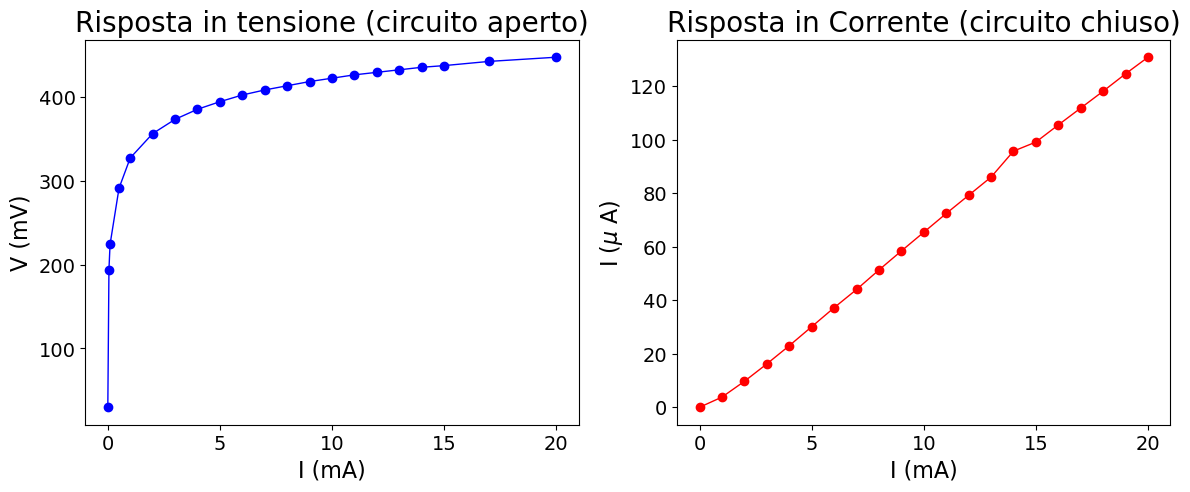

In [129]:
# In questa cella si procede al plot dei dati
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14,5])

titlefontsize, labelfontsize, tickfontsize=20, 16, 14
markersize, linewidth = 6, 1

ax1.set_title('Risposta in tensione (circuito aperto)', size=titlefontsize)
ax1.plot(I_led_circuito_aperto, V, '-o', markersize=markersize, linewidth=linewidth, color='blue')
ax1.set_xlabel('I (mA)', size=labelfontsize)
ax1.set_ylabel('V (mV)', size=labelfontsize)
ax1.tick_params(labelsize=tickfontsize)

ax2.set_title('Risposta in Corrente (circuito chiuso)', size=titlefontsize)
ax2.plot(I_led_cortocircuito, I_ph, '-o', markersize=markersize, linewidth=linewidth, color='red')
ax2.set_xlabel('I (mA)', size=labelfontsize)
ax2.set_ylabel('I ($\mu$ A)', size=labelfontsize)
ax2.tick_params(labelsize=tickfontsize)

Su questi primi dati si possono effettuare due fit:
* Un fit lineare sui dati della risposta in corrente per stimare il fattore $\beta$ nella formula $I_{ph} = \beta I_{LED}$
* Un fit non lineare a due parametri sui dati della risposta in tensione; i parametri considerati sono $I_0$, la corrente inversa di saturazione, e $n$, il fattore di idealità, introdotto per tenere conto dei processi di ricombinazione radiativa all'interno del diodo.

Per ricavare la formula da utilizzare per questo secondo fit si parte dall'equazione scritta all'inizio, introducendo il fattore di idealità:
$$I = I_0 \left(e^{\frac{qV}{nkT}} - 1\right) - I_{ph}$$
da cui, ponendo $I=0$ (si sta trattando il caso a circuito aperto), operando la sostituzione $I_{ph} = \beta I_{LED}$ e esplicitando $V$ si ottiene:
$$V = \frac{n k T}{q} \ln\left( \frac{\beta}{I_0} I_{LED} + 1\right)$$

Di seguito vengono riportate le celle di codice in cui si definiscono le funzioni di fit e si svolgono i calcoli.

**NOTA**: data la struttura della formula, occore effettuare prima il fit lineare per ricavare $\beta$, tenuto poi fisso nel secondo fit (altrimenti i valori di numeratore e denominatore della frazione $\beta / I_0$ non possono essere univocamente determinati dalla funzione di fit).

In [119]:
def linear(I_led, beta):
    return I_led * beta

def nonlin(I_led, beta, I_0, n):
    return ((n * Boltzmann * temperature) / (electron_charge)) * np.log((beta / I_0) * I_led + 1)

# Funzione utile per il calcolo dell'R^2
def r_squared(actual, predicted):
    residuals = actual - predicted
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum( (actual - np.mean(actual))**2 )
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [120]:
# Primo fit
# Si definiscono i bounds per il parametro beta
min, max = [0.000001], [1]
bounds = [min, max]
ndata = len(I_led_cortocircuito)        #numero di dati analizzati


# Si effettua il fit lineare a un parametro con la funzione linear (la divisione per 1000 serve
# per mantenere coerenza tra le unità di misura, dato che I_ph è misurata in micro-Ampere
popt, pcov=sop.curve_fit(linear, I_led_cortocircuito, I_ph/1000, bounds=bounds)
beta = popt[0]   # questo è il valore di I0 che risulta dal fit
# Si effettua la seguente operazione per ottenere la deviazione standard e non lo standard error
sigma = np.sqrt(ndata*np.diag(pcov))
r_sq_beta_fit = r_squared(I_ph/1000, linear(I_led_cortocircuito, beta))

print("Primo fit:")
print('Valore fittato per beta=', "{:.3g}".format(beta), 'deviazione standard=',"{:.3g}".format(sigma[0]))    # Stampa dei risultati ottenuti
print("R^2 = ", "{:.5g}".format(r_sq_beta_fit))


# Secondo fit
# Definizione dei bounds
I_0_min, I_0_max = 1e-10, 1
n_min, n_max = 0.5, 5
min, max = [I_0_min, n_min], [I_0_max, n_max]
bounds = [min, max]
ndata = len(I_led_circuito_aperto)          #numero di dati analizzati


# Si effettua ora il fit non lineare per i parametri I_0 e n
# ATTENZIONE: è stata utilizzata una lambda function perché il valore di beta è fisso e NON deve essere fittato
# Per il resto la procedura è uguale alla precedente
popt, pcov = sop.curve_fit(lambda I_led, I_0, n : nonlin(I_led, beta, I_0, n), I_led_circuito_aperto/1000, V/1000, bounds=bounds)
I_0 = popt[0]
n = popt[1]
sigma = np.sqrt(ndata*np.diag(pcov))
r_sq_nonlin_fit = r_squared(V/1000, nonlin(I_led_circuito_aperto/1000, beta, I_0, n))
print("\nSecondo fit:")
print('Valore fittato per I_0=', "{:.3g}".format(I_0), 'deviazione standard=',"{:.3g}".format(sigma[0]))
print('Valore fittato per n=', "{:.3g}".format(n), 'deviazione standard=',"{:.3g}".format(sigma[1]))
print("R^2 = ", "{:.5g}".format(r_sq_nonlin_fit))


Primo fit:
Valore fittato per beta= 0.00656 deviazione standard= 0.000167
R^2 =  0.99784

Secondo fit:
Valore fittato per I_0= 6.26e-09 deviazione standard= 1.32e-08
Valore fittato per n= 1.77 deviazione standard= 0.224
R^2 =  0.99303


Si riportano infine i plot iniziali confrontati con l'andamento fittato

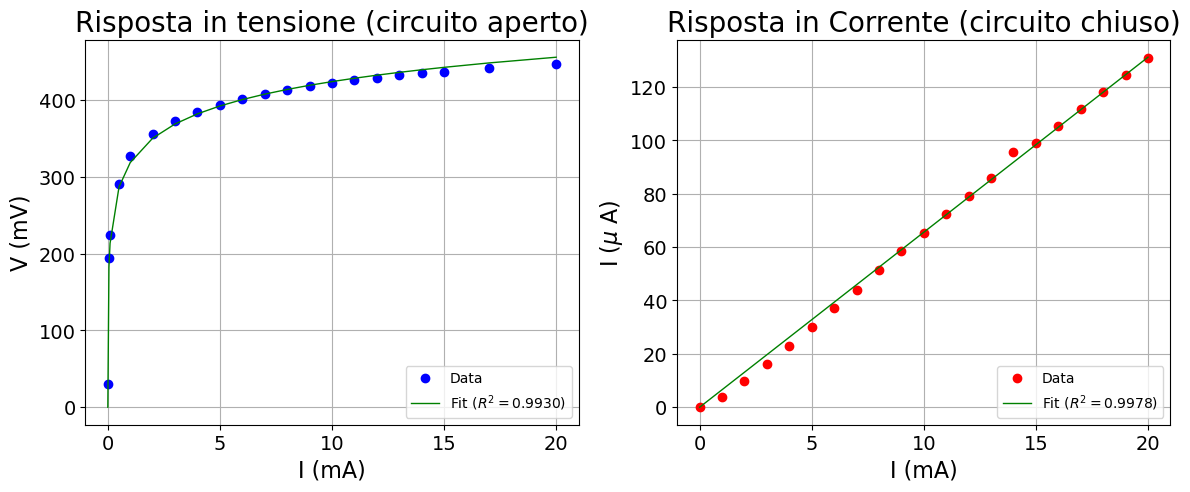

In [131]:
# In questa cella si procede al plot dei dati
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14,5])

ax1.set_title('Risposta in tensione (circuito aperto)', size=titlefontsize)
ax1.plot(I_led_circuito_aperto, V, 'o', markersize=markersize, color='blue', label="Data")
ax1.plot(I_led_circuito_aperto, nonlin(I_led_circuito_aperto/1000, beta, I_0, n)*1000, linewidth=linewidth, color='green', label="Fit ($R^2=${:.4f})".format(r_sq_nonlin_fit))
ax1.set_xlabel('I (mA)', size=labelfontsize)
ax1.set_ylabel('V (mV)', size=labelfontsize)
ax1.tick_params(labelsize=tickfontsize)
ax1.legend(loc="lower right")
ax1.grid(True)

ax2.set_title('Risposta in Corrente (circuito chiuso)', size=titlefontsize)
ax2.plot(I_led_cortocircuito, I_ph, 'o', markersize=markersize, color='red', label="Data")
ax2.plot(I_led_cortocircuito, linear(I_led_cortocircuito, beta)*1000, linewidth=linewidth, color='green', label="Fit ($R^2=${:.4f})".format(r_sq_beta_fit))
ax2.set_xlabel('I (mA)', size=labelfontsize)
ax2.set_ylabel('I ($\mu$ A)', size=labelfontsize)
ax2.tick_params(labelsize=tickfontsize)
ax2.grid(True)
ax2.legend(loc="lower right");

#### Coclusioni fase 1
I dati ottenuti in questa prima fase possono ritenersi soddisfacenti, con i dati ottenuti per i parametri nei range previsti. L'unica pecca è la deviazione standard stranamente alta sul parametro $I_0$, che però non sembra incidere troppo vista anche l'accuratezza del fit.

## Fase 2: risposta in tensione su una resistenza di carico
In questa fase si mantiene una struttura simile a quella della fase precedente, ma mettendo una resistenza in serie al fotodiodo. Lo schema circuitale è il seguente:
<br><center><img src="Laboratorio_Fisica_3/Accoppiamento_LED-PD/img/Accoppiamento_Led-PD_Fase2.png"/></center><br>

Per questo circuito devono quindi valere le seguenti relazioni (senza tenere conto del fattore di idealità):
$$I_D = I_0 \left(e^{\frac{qV_D}{kT}} - 1\right) - I_{ph} \hspace{1.5cm} I_R = -\frac{V_D}{R} \hspace{1.5cm} I_D = I_R$$
dove i pedici indicano il componente a cui si riferisce il dato (D: fotodiodo, R: resistenza).
Combinando i risultati si trova che:
$$I_{ph} = I_0 \left(e^{\frac{qV_D}{kT}} - 1\right) + \frac{V_D}{R}$$

Si nota quindi subito che per $R$ piccolo (e $V_D$ piccolo) prevale il termine $\frac{V_D}{R}$ (comportamento lineare), mentre per $R$ grande (e al crescere di $V_D$) prevale il termine $I_0 \left(e^{\frac{qV_D}{kT}} - 1\right)$ (comportamento esponenziale).

Questo tipo di andamento è stato correttamente osservato in questa fase dell'esperienza come si evince dai grafici riportati di seguito.

In [124]:
data = pd.read_csv(rad + "data/R_carico-fase_2.csv")

print("Dataframe da csv: ")
print(data)
headers = data.keys()

# Creo gli array numpy per l'analisi successiva
I_led = data['I_led'].to_numpy()
R_500 = data['R_500'].to_numpy()
R_1000 = data['R_1000'].to_numpy()
R_5000 = data['R_5000'].to_numpy()
R_10000 = data['R_10000'].to_numpy()

Dataframe da csv: 
    I_led  R_500  R_1000  R_5000  R_10000
0       0   0.00    0.00     0.0      0.0
1       1   2.04    3.97    20.3     40.0
2       2   5.05    9.87    50.0     99.0
3       3   8.37   16.35    83.0    163.2
4       4  11.83   23.10   117.0    229.0
5       5  15.37   30.00   152.2    287.0
6       6  18.94   37.00   187.0    325.0
7       7  22.50   44.00   222.0    348.0
8       8  26.10   51.00   257.0    365.0
9       9  29.80   58.00   287.0    376.0
10     10  33.30   64.90   312.0    386.0
11     11  36.90   71.70   333.0    393.0
12     12  40.30   78.60   348.0    400.0
13     13  43.80   85.20   361.0    405.0
14     14  47.10   91.90   371.0    410.0
15     15  50.40   98.50   379.0    414.0
16     16  53.60  104.80   386.0    418.0
17     17  56.80  111.00   392.0    421.0
18     18  60.00  117.40   397.0    424.0
19     19  63.00  123.40   402.0    427.0
20     20  66.00  129.20   405.0    429.0


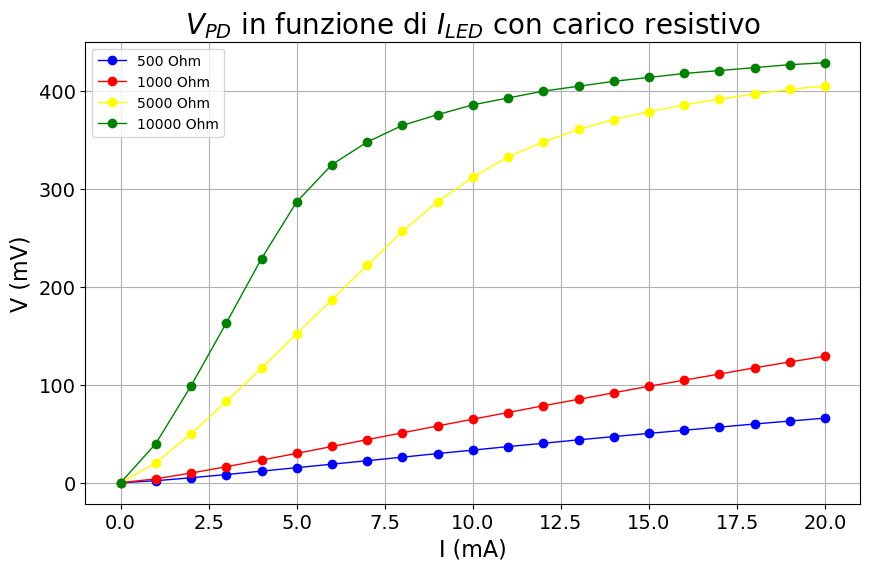

In [142]:
plt.figure(figsize=[10,6])
plt.title("$V_{PD}$ in funzione di $I_{LED}$ con carico resistivo", size=titlefontsize)
plt.plot(I_led, R_500, '-o', markersize=markersize, linewidth=linewidth, color='blue', label="500 Ohm")
plt.plot(I_led, R_1000, '-o', markersize=markersize, linewidth=linewidth, color='red', label="1000 Ohm")
plt.plot(I_led, R_5000, '-o', markersize=markersize, linewidth=linewidth, color='yellow', label="5000 Ohm")
plt.plot(I_led, R_10000, '-o', markersize=markersize, linewidth=linewidth, color='green', label="10000 Ohm")
plt.xlabel('I (mA)', size=labelfontsize)
plt.ylabel('V (mV)', size=labelfontsize)
plt.tick_params(labelsize=tickfontsize)
plt.grid(True)
plt.legend();

## Fase 3: caratteristica I-V in funzione della resistenza
In questa parte finale dell'esperienza si sostituisce la resistenza sul fotodiodo con un trimmer (ovvero una resistenza variabile), attaccando anche un amperometro in serie. Di seguito viene riportato lo schema circuitale.

<br><center><img src="Laboratorio_Fisica_3/Accoppiamento_LED-PD/img/Accoppiamento_Led-PD_Fase3.png"/></center><br>

Si procede nella misura tenendo fissa la corrente di alimentazione sul LED (fissando di conseguenza $I_{ph}$, dato che $I_{LED} \propto I_{ph}$) e cambiando il valore della resistenza, ottenendo quindi le coppie di valori ($I_D$, $V_D$), dove il pedice indica che sono valori di corrente e tensione relativi al diodo. In questo modo, si è in grado di ricostruire successivamente la curva caratteristica del fotodiodo.

Si sono ripetute le misure con valori di $I_{LED}$ pari a 10 mA e 20 mA. Di seguito il grafico della curva caratteristica.

In [141]:
data = pd.read_csv(rad + "data/trimmer-fase_3.csv")

print("Dataframe da csv: ")
print(data)
headers = data.keys()

# Creo gli array numpy per l'analisi successiva
I_10mA = data['I_10mA'].to_numpy()[:-3]     # gli ultimi 3 valori nel dataframe sono NaN, avendo preso meno misure per l'illuminazione a 10mA
V_10mA = data['V_10mA'].to_numpy()[:-3]
I_20mA = data['I_20mA'].to_numpy()
V_20mA = data['V_20mA'].to_numpy()

Dataframe da csv: 
    I_10mA  V_10mA  I_20mA  V_20mA
0    -63.9    10.0  -135.3    10.0
1    -63.7    30.0  -134.8    28.4
2    -64.7    50.0  -134.5    49.9
3    -64.8    70.8  -134.4    74.4
4    -64.7    90.4  -134.4    91.8
5    -64.7   111.0  -134.6   111.4
6    -64.8   130.3  -134.2   133.6
7    -65.8   153.5  -134.0   152.6
8    -65.9   171.0  -134.1   169.5
9    -65.8   190.0  -133.9   193.6
10   -65.6   211.0  -133.7   210.0
11   -65.4   234.0  -133.2   234.0
12   -65.2   251.0  -132.7   249.0
13   -64.5   271.0  -131.8   269.0
14   -63.3   292.0  -130.2   289.0
15   -61.2   312.0  -126.9   312.0
16   -58.0   332.0  -123.1   329.0
17   -53.2   350.0  -115.8   350.0
18   -49.4   360.0  -111.1   359.0
19   -44.7   370.0  -104.4   370.0
20   -39.5   379.0   -97.9   379.0
21   -33.8   390.0   -88.5   389.0
22   -29.1   395.0   -82.9   395.0
23   -24.6   400.0   -77.6   399.0
24   -20.6   404.0   -69.9   406.0
25   -18.2   406.0   -64.3   410.0
26   -16.9   407.0   -56.7   415.0
2

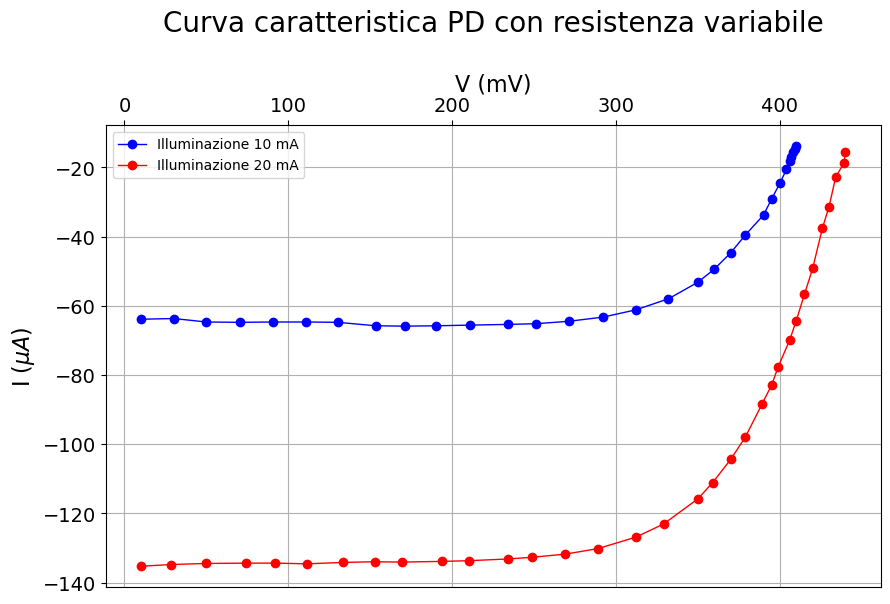

In [159]:
fig, ax = plt.subplots(1, 1, figsize=[10,6])
ax.set_title("Curva caratteristica PD con resistenza variabile", size=titlefontsize, pad=30)
ax.plot(V_10mA, I_10mA, '-o', markersize=markersize, linewidth=linewidth, color='blue', label="Illuminazione 10 mA")
ax.plot(V_20mA, I_20mA, '-o', markersize=markersize, linewidth=linewidth, color='red', label="Illuminazione 20 mA")
ax.xaxis.tick_top()
ax.set_xlabel('V (mV)', size=labelfontsize)
ax.xaxis.set_label_position('top')
ax.set_ylabel('I ($\mu A$)', size=labelfontsize)
ax.tick_params(labelsize=tickfontsize)
ax.grid(True)
ax.legend();

A questo punto si procede calcolando la resistenza $R = V/I$ e la potenza $P = VI$ da ogni coppia di dati, plottando infine la potenza in funzione della resistenza. In questo modo, si è in grado di trovare il valore della resistenza corrispondente alla potenza massima. Sotto la cella di codice verranno stampati tali valori.

La potenza massima per I_LED = 10mA si ha per R = 5724.1 Ohm
La potenza massima per I_LED = 20mA si ha per R = 3022.5 Ohm


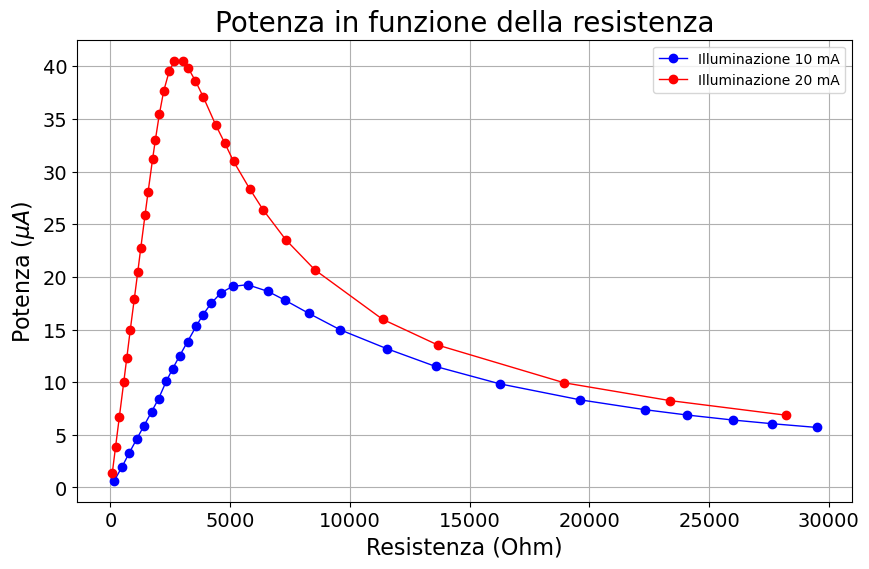

In [168]:
# Calcolo di resistenza e potenza
# si mette un meno per ottenere potenza positiva, dato che la corrente è negativa
# inoltre, si divide la corrente per 1000 dato che è in micro-Ampere
R_10mA = V_10mA / -(I_10mA/1000)
R_20mA = V_20mA / -(I_20mA/1000)

P_10mA = V_10mA * -(I_10mA/1000)
P_20mA = V_20mA * -(I_20mA/1000)

# Plot del grafico della potenza in funzione della resistenza
fig, ax = plt.subplots(1, 1, figsize=[10,6])
ax.set_title("Potenza in funzione della resistenza", size=titlefontsize)
ax.plot(R_10mA, P_10mA, '-o', markersize=markersize, linewidth=linewidth, color='blue', label="Illuminazione 10 mA")
ax.plot(R_20mA, P_20mA, '-o', markersize=markersize, linewidth=linewidth, color='red', label="Illuminazione 20 mA")

ax.set_xlabel('Resistenza (Ohm)', size=labelfontsize)
ax.set_ylabel('Potenza ($\mu A$)', size=labelfontsize)
ax.tick_params(labelsize=tickfontsize)
ax.grid(True)
ax.legend();

# Calcolo e stampa della resistenza necessaria per ottenere la massima potenza
print("La potenza massima per I_LED = 10mA si ha per R =", "{:.5g}".format(R_10mA[P_10mA.argmax()]), "Ohm")
print("La potenza massima per I_LED = 20mA si ha per R =", "{:.5g}".format(R_20mA[P_20mA.argmax()]), "Ohm")